In [1]:
import matplotlib.pyplot as plt

import skimage.filters as skf
from skimage.measure import label
from skimage.morphology import closing
from skimage.color import rgba2rgb, rgb2gray

import glob
import os
import numpy as np
import skimage.io as sio
from tqdm import tqdm

import matplotlib as mpl
mpl.rc('image', cmap='gray')
mpl.rc('patch', ec='k', fc='k')
mpl.rc('lines', c='k')

In [2]:
image_path = "/pscratch/sd/a/ajtritt/SDBR/bisabolene_CN/S4"
image_path = "/Users/ajtritt/projects/abpdu/bisabolene_CN/S4"

In [72]:
images = list()
hts = list()
for subdir in sorted(glob.glob(f"{image_path}/*")):
    hts.append(os.path.basename(subdir))
    images.append(sio.imread(glob.glob(os.path.join(subdir, f"*_10.tif"))[0])[:, :, 0])

images = np.array(images)

# Some functions for viewing images and the results of segmentations

In [217]:
import matplotlib.patches as patches
def calc_box(mask):
    mask = mask.astype(int)
    Y, X = np.where(mask == 1)
    Xx, Xn = X.max(), X.min()
    Yx, Yn = Y.max(), Y.min()
    return patches.Rectangle((Xn, Yx), Xx-Xn, Yn-Yx, linewidth=1, edgecolor='r', facecolor='none')


def trim_box(mask, img, crop=None):
    mask = mask.astype(int)
    X, Y = np.where(mask == 1)
    Xx, Xn = X.max(), X.min()
    Yx, Yn = Y.max(), Y.min()
    if crop is not None:
        Ydim = Yx - Yn
        Xdim = Xx - Xn
        Xpad = (crop[0] - Xdim) // 2
        Ypad = (crop[1] - Ydim) // 2
        Xx += Xpad
        Xn -= Xpad
        Yx += Ypad
        Yn -= Ypad
        if (Xx - Xn) != crop[0]:
            Xx += 1
        if (Yx - Yn) != crop[0]:
            Yx += 1
    return img[Xn: Xx, Yn: Yx]


def plot_images(func=lambda x: x, draw_box=False, draw_mask=True):
    fig, axes = plt.subplots(3, 4, figsize=(8, 6))
    for img, ax, ht in zip(images, axes.ravel(), hts):
        ax.tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)
        tmp_img = func(img)
        if draw_mask:
            ax.imshow(tmp_img, cmap='gray')
        else:
            ax.imshow(img, cmap='gray')
        ax.set_xlabel(f"{ht} - {img.mean():.1f}")
        if draw_box:
            patch = calc_box(tmp_img)
            ax.add_patch(patch)
            

## View some images

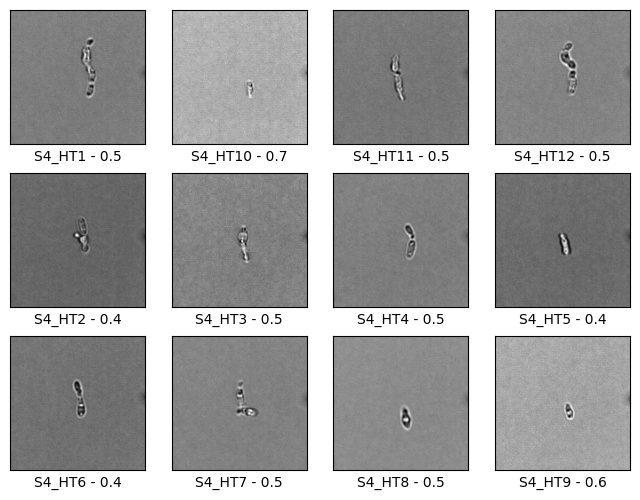

In [5]:
plot_images()
plt.savefig('samples.png')

# Filtering garbage data

Some images are complete failures. One indication seems to be a high variance in pixel values. Below are some bad images

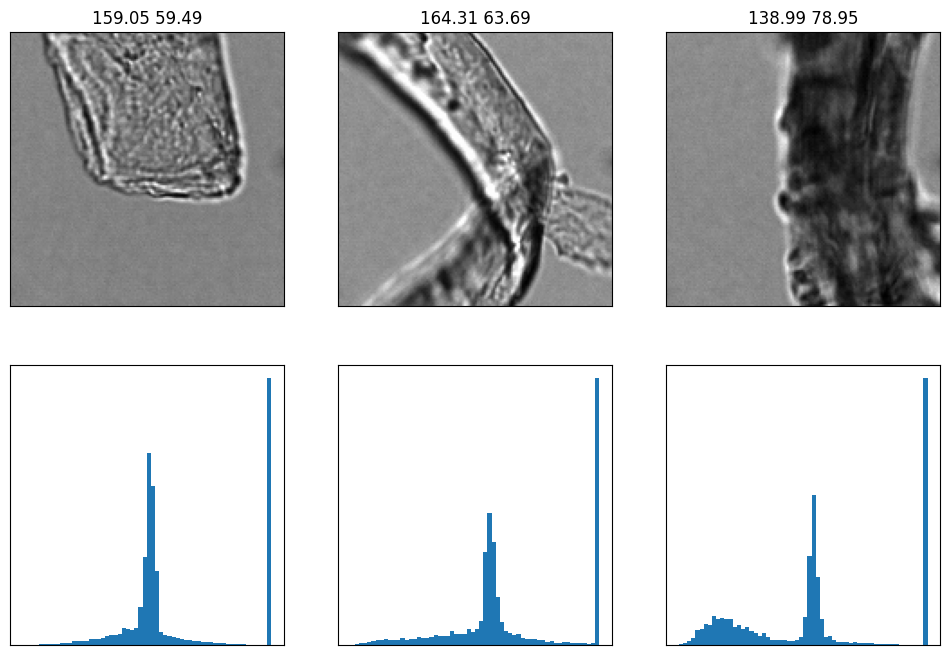

In [116]:
bad_images = ["S4_HT2/Rhodo_Ambr01_S4_HT1 - HT2_S4_HT2dil5000x_F-1_308.tif",
              "S4_HT5/Rhodo_Ambr01_S4_HT3 - 4 - 5_S4_HT5dil5000x_F-1_124.tif", 
              "S4_HT11/Rhodo_Ambr01_S4_HT9 - 10 - 11_S4_HT11dil5000x_F0_12.5_693.tif"]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for im_path, ax in zip(bad_images, axes.T):
    ax[0].tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)
    ax[1].tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)
    im = sio.imread(os.path.join(image_path, im_path))
    ax[0].imshow(im, cmap='gray')
    ax[0].set_title(f"{im.mean():.2f} {im.std():.2f}")
    ax[1].hist(im.ravel(), bins=60)

Compare this to the variance in good images:

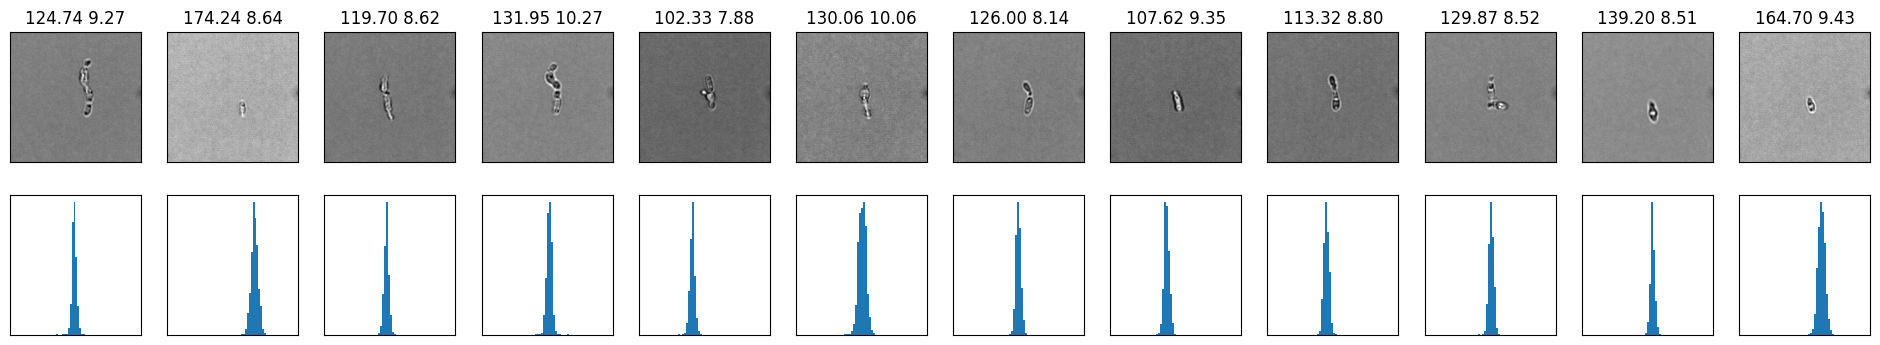

In [120]:
fig, axes = plt.subplots(2, 12, figsize=(24, 4))
for im, ax in zip(images, axes.T):
    ax[0].tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)
    ax[1].tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)
    ax[0].imshow(im, cmap='gray')
    ax[0].set_title(f"{im.mean():.2f} {im.std():.2f}")
    ax[1].hist(im.ravel(), bins=60)
    

Based on this, let's remove any images with $\sigma > 15$ 

# Thresholding

First lets try something out of the box.

## Standard Otsu thresholding

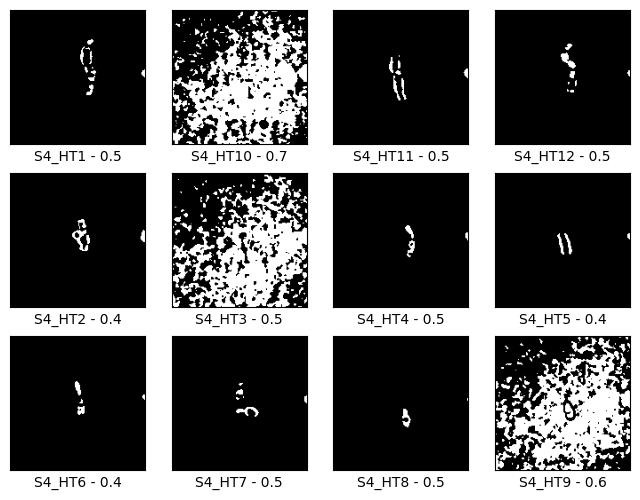

In [6]:
def threshold(img):
    blur = skf.gaussian(img)
    return blur < skf.threshold_otsu(blur)
plot_images(threshold)

### A closer look

Ope, well that didn't go so well!

Lets zoom in and look closer at a single cell to see what's going on.

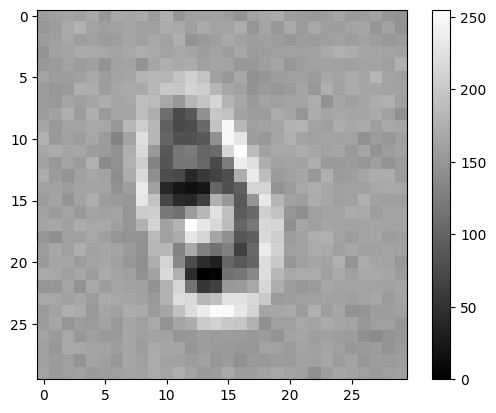

In [123]:
plt.imshow(images[11][70:100][:, 70:100])
plt.colorbar()

Here, we can see that the cell is composed of pixels above and below the average pixel value

### Histogram of the pixels

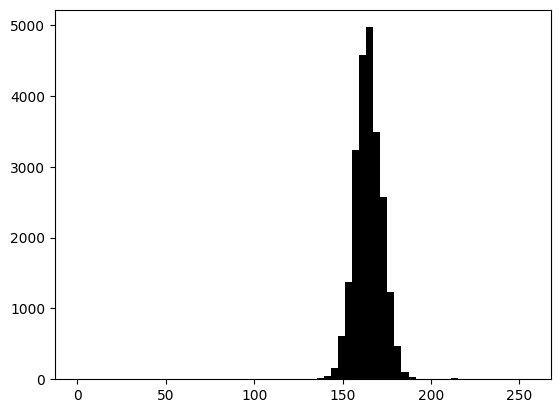

In [124]:
plt.hist(images[11].ravel(), bins=64, color='k');

### Ignore the tails
Let's see what $1 \sigma$ looks like

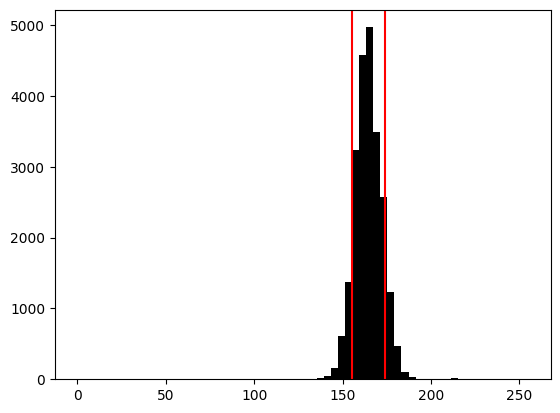

In [125]:
img = images[11]
plt.hist(img.ravel(), bins=64, color='k');
mean = img.ravel().mean()
std = img.ravel().std()
nsig = 1
plt.axvline(mean - nsig*std, color='r')
plt.axvline(mean + nsig*std, color='r')

## Outlier thresholding
Make mask based on values that are $N \sigma$ from the mean.


First, lets ignore data at the borders (it appears there are some imaging artefacts). Then threshold above and below $N \sigma$ away from the mean. By default, $N = 1$. Finally, apply successive median filters to get rid of any extra noise.

In [126]:
def outlier_threshold_tol(img, tol=0.001, max_med=10, ntrim=15, nsig=1):
    """
    Args:
        tol (float)      : the tolerance for applying successive median filters. If the change is less than this, stop applying filters
        max_med (int)    : the maximum number of median filters to apply
        ntrim (int)      : the size of the border to ignore
        nsig (int)       : the number of standard deviations above/below which to keep set the threshold
    """
    mean = img.ravel().mean()
    std = img.ravel().std()
    mask = np.logical_or(img < mean - nsig*std, img > mean + nsig*std).astype(int)
    if ntrim > 0:
        mask[:ntrim] = 0
        mask[-ntrim:] = 0
        mask[:, :ntrim] = 0
        mask[:, -ntrim:] = 0
    
    for i in range(max_med):
        tmp = skf.median(mask.astype(int))
        diff = (mask != tmp).mean()
        if diff < tol:
            break
        mask = tmp

    return mask
outlier_threshold_tol(images[5], max_med=8);

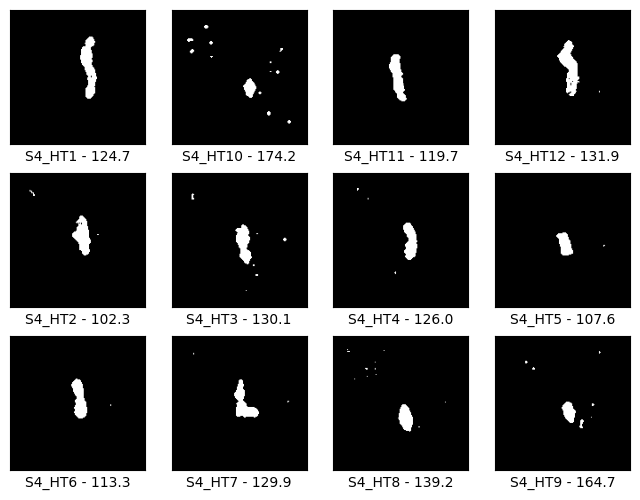

In [127]:
plot_images(outlier_threshold_tol)

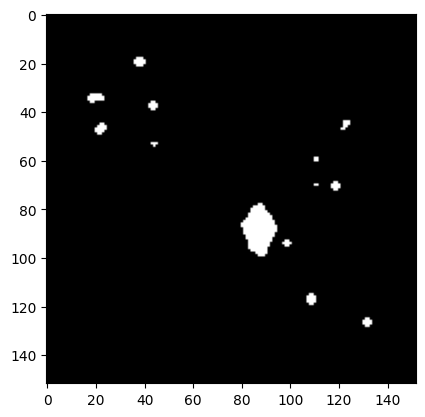

In [128]:
plt.imshow(outlier_threshold_tol(images[1]), cmap='gray')

## Filter any remaining noise.

As we can see in some of the thresholded figures above, we still get some noise. Lets get rid of that by closing the remaining blobs and clustering (i.e. labelling) them. Then keep the label that consists of more than 50% of the remaining pixels.

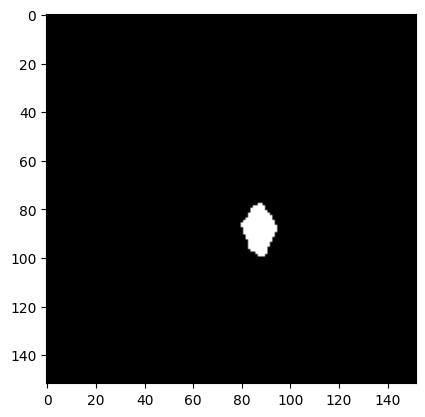

In [198]:
from sklearn.cluster import DBSCAN

def outlier_cluster(img, frac=0.3):
    mask = outlier_threshold_tol(img, ntrim=15)
    mask = closing(mask)
    if frac is not None:
        labels = label(mask)
        counts = np.bincount(labels.ravel())[1:]
        counts = (counts / counts.sum())
        cell_cluster_id = np.where(counts > frac)[0]
        if len(cell_cluster_id) == 0:
            raise ValueError("Unable to find one majority cluster")

        cell_cluster_id = cell_cluster_id[0] + 1
        mask = (labels == cell_cluster_id).astype(int)
    return mask
plt.imshow(outlier_cluster(images[1]), cmap='gray')

### Test out this segmentation on other images

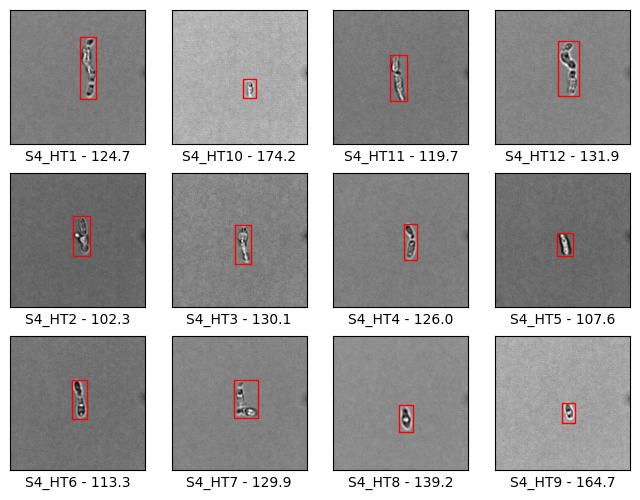

In [199]:
plot_images(outlier_cluster, draw_box=True, draw_mask=False)

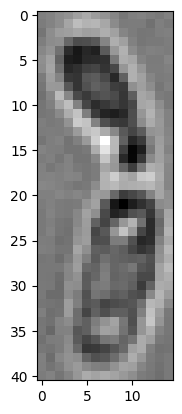

In [200]:
mask = outlier_cluster(images[6])
new_img = trim_box(mask, images[6])
plt.imshow(new_img, cmap='gray')

In [134]:
n_unseg = 0
total = 0
masks = list()
for tif_path in tqdm(sorted(glob.glob(f"{image_path}/*/*.tif"))):
    total += 1
    target = tif_path.replace("S4/", "S4_seg/")
    os.makedirs(os.path.dirname(target), exist_ok=True)
    img = sio.imread(tif_path)[:, :, 0]   
    try:
        #TODO: Add check for garbage images i.e. overdispersed images.
        if img.std() > 15:
            raise ValueError("StdDev of pixels is quite high, this is probably a bad image")
        mask = outlier_cluster(img)
    except ValueError:
        target = tif_path.replace("S4/", "S4_unseg/")
        os.makedirs(os.path.dirname(target), exist_ok=True)
        sio.imsave(target, img)
        n_unseg += 1
        continue
    new_img = trim_box(mask, img)
    sio.imsave(target, new_img)

100%|██████████| 120000/120000 [07:44<00:00, 258.31it/s]


In [142]:
cropped_images = list()
cropped_hts = list()
for subdir in sorted(glob.glob(f"{image_path}_seg/*")):
    cropped_hts.append(os.path.basename(subdir))
    cropped_images.append(sio.imread(glob.glob(os.path.join(subdir, f"*_10.tif"))[0]))

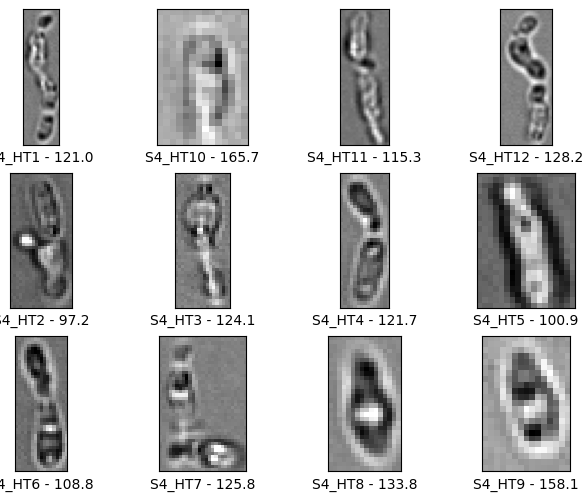

In [143]:
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
for img, ax, ht in zip(cropped_images, axes.ravel(), cropped_hts):
    ax.tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)
    ax.imshow(img, cmap='gray')
    ax.set_xlabel(f"{ht} - {img.mean():.1f}")

In [165]:
unseg_images = list()

for tif_path in tqdm(sorted(glob.glob(f"{image_path}_unseg/S4*/*.tif"))):
    img = sio.imread(tif_path)   
    unseg_images.append(img)
unseg_images = np.array(unseg_images)

100%|██████████| 1589/1589 [00:00<00:00, 4307.21it/s]


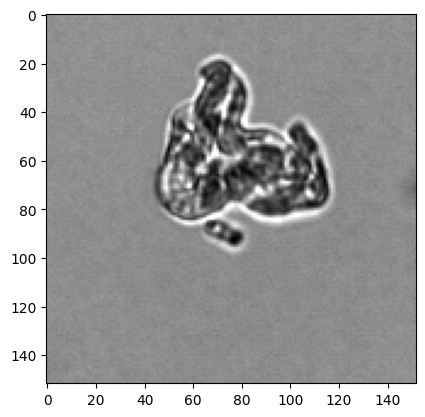

In [201]:
plt.imshow(unseg_images[0])

27.13731426288682


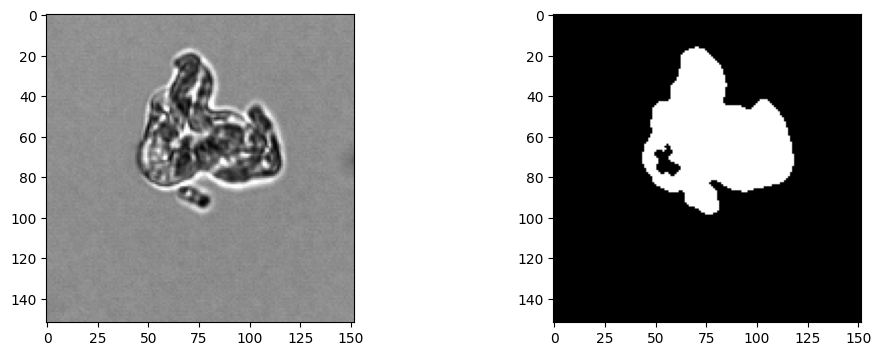

In [203]:
i = 0
print(unseg_images[i].std())
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(unseg_images[i])
axes[1].imshow(outlier_cluster(unseg_images[i]))

In [193]:
unseg40 = list()
for i, img in enumerate(unseg_images):
    try:
        get_mask(img, frac=0.3)
    except ValueError:
        unseg40.append(i)
unseg40 = np.array(unseg40)

9.691817649535016


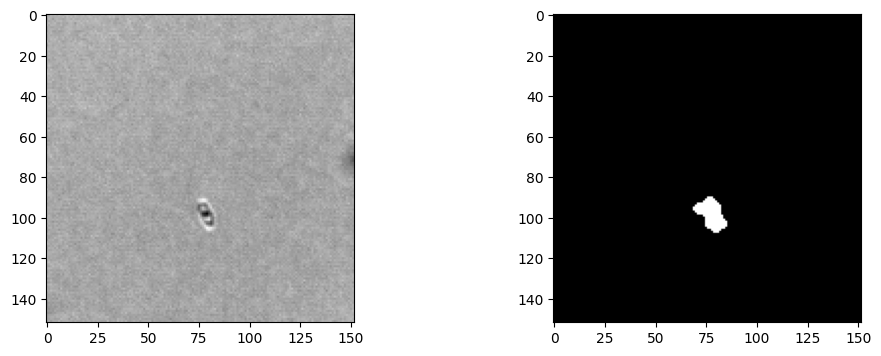

In [209]:

i = 2
print(unseg_images[i].std())
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(unseg_images[i])
mask = get_mask(unseg_images[i], frac=0.3)
axes[1].imshow(mask)

# Outstanding issue

Should I pad to a consistent size after segmentation so we pad with "real" image, rather than constant zeros? 

If so, this is the function for doing that

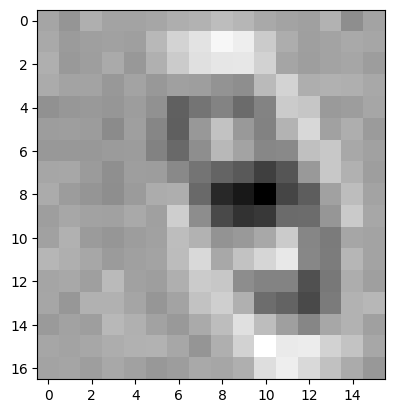

In [216]:
def trim_box(mask, img, crop=None):
    mask = mask.astype(int)
    X, Y = np.where(mask == 1)
    Xx, Xn = X.max(), X.min()
    Yx, Yn = Y.max(), Y.min()
    if crop is not None:
        Ydim = Yx - Yn
        Xdim = Xx - Xn
        Xpad = (crop[0] - Xdim) // 2
        Ypad = (crop[1] - Ydim) // 2
        Xx += Xpad
        Xn -= Xpad
        Yx += Ypad
        Yn -= Ypad
        if (Xx - Xn) != crop[0]:
            Xx += 1
        if (Yx - Yn) != crop[0]:
            Yx += 1
    return img[Xn: Xx, Yn: Yx]

plt.imshow(trim_box(mask, unseg_images[i]))

21.78986740027694


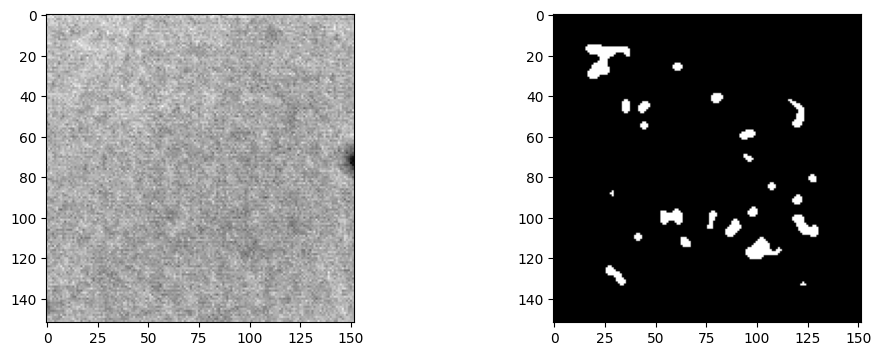

In [195]:
i = unseg40[0]
print(unseg_images[i].std())
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(unseg_images[i])
axes[1].imshow(get_mask(unseg_images[i], frac=None))

In [196]:
unseg40

array([ 222,  388,  690,  691,  803,  873,  876,  900,  901,  912,  913,
       1277, 1305, 1320, 1323, 1324, 1440])

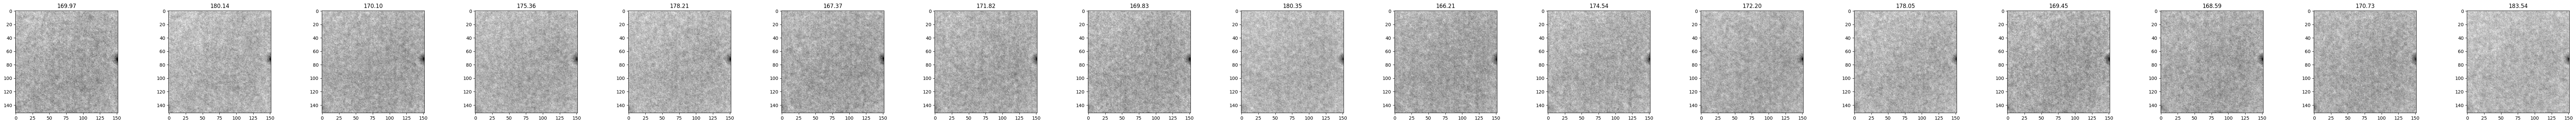

In [197]:
fig, axes = plt.subplots(1, 17, figsize=(100, 4))
for img_i, ax in zip(unseg40, axes):
    ax.imshow(unseg_images[img_i])
    ax.set_title(f"{unseg_images[img_i].mean():.2f}")

In [89]:
stdevs = list()
means = list()
for tif_path in tqdm(sorted(glob.glob(f"{image_path}/*/*.tif"))):
    img = sio.imread(tif_path)[:, :, 0]
    stdevs.append(img.std())
    means.append(img.mean())
stdevs = np.array(stdevs)
means = np.array(means)

100%|██████████| 120000/120000 [01:31<00:00, 1306.26it/s]


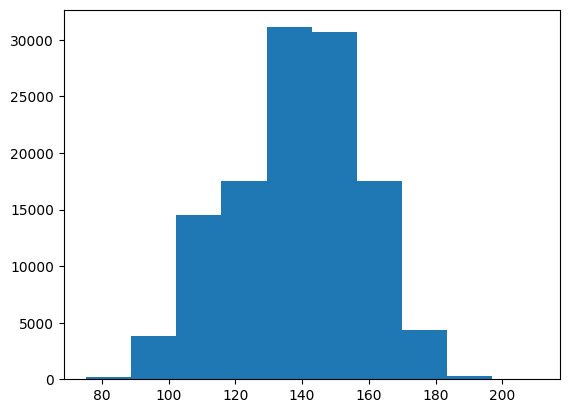

In [98]:
plt.hist(means);

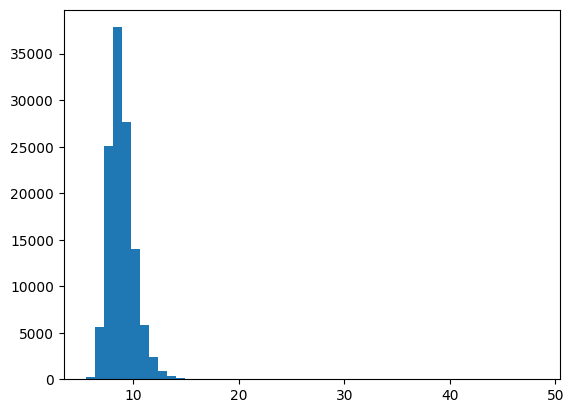

In [99]:
plt.hist(stdevs, bins=50);

In [100]:
plt.

133